In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Project root (Windows path)
path = r"C:\Users\Karinthip\DataProject\BankFraudDetection"

df = pd.read_csv("bank_transactions_data_2.csv")

# Convert datetime columns
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])
df["PreviousTransactionDate"] = pd.to_datetime(df["PreviousTransactionDate"])

df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [2]:
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)

Shape: (2512, 16)

Data Types:
 TransactionID                      object
AccountID                          object
TransactionAmount                 float64
TransactionDate            datetime64[ns]
TransactionType                    object
Location                           object
DeviceID                           object
IP Address                         object
MerchantID                         object
Channel                            object
CustomerAge                         int64
CustomerOccupation                 object
TransactionDuration                 int64
LoginAttempts                       int64
AccountBalance                    float64
PreviousTransactionDate    datetime64[ns]
dtype: object


In [3]:
numeric_cols = [
    "TransactionAmount",
    "CustomerAge",
    "TransactionDuration",
    "LoginAttempts",
    "AccountBalance"
]

df[numeric_cols].describe()


,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966
std,291.946243,17.792198,69.963757,0.602662,3900.942499
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


In [4]:
# ดูยอดรวมของแต่ละอาชีพ
print("\n1. ยอดเงินเฉลี่ยแยกตามอาชีพ:")
print(df.groupby('CustomerOccupation')['TransactionAmount'].mean())


1. ยอดเงินเฉลี่ยแยกตามอาชีพ:
CustomerOccupation
Doctor      292.700174
Engineer    289.040096
Retired     294.533673
Student     313.220746
Name: TransactionAmount, dtype: float64


In [5]:
# ดูช่องทางที่คนใช้บริการบ่อยที่สุด
print("\n2. จำนวนการใช้งานในแต่ละช่องทาง:")
print(df['Channel'].value_counts())


2. จำนวนการใช้งานในแต่ละช่องทาง:
Channel
Branch    868
ATM       833
Online    811
Name: count, dtype: int64


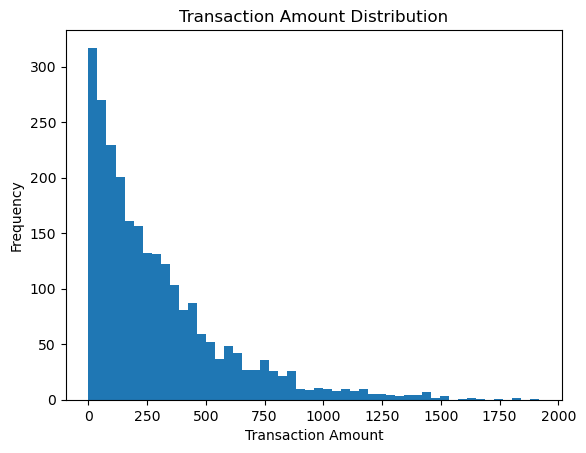

In [6]:
plt.figure()
plt.hist(df["TransactionAmount"], bins=50)
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()


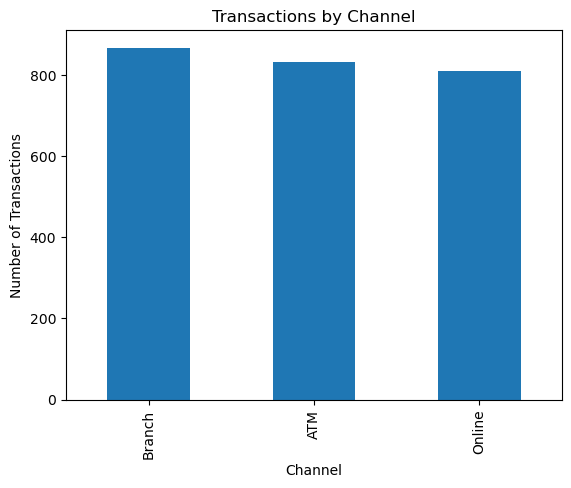

In [7]:
channel_counts = df["Channel"].value_counts()

plt.figure()
channel_counts.plot(kind="bar")
plt.title("Transactions by Channel")
plt.xlabel("Channel")
plt.ylabel("Number of Transactions")
plt.show()

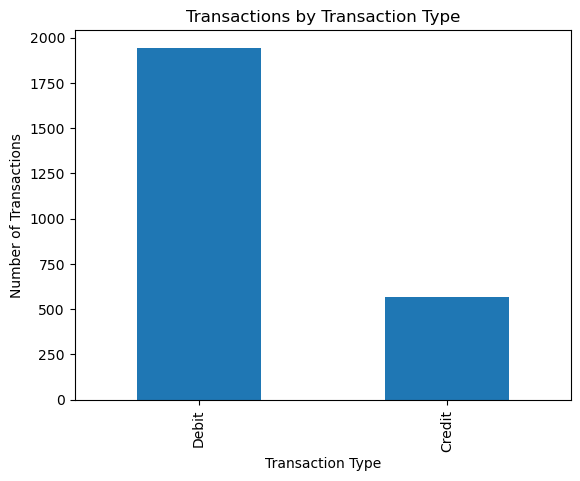

In [8]:
tx_type_counts = df["TransactionType"].value_counts()

plt.figure()
tx_type_counts.plot(kind="bar")
plt.title("Transactions by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Number of Transactions")
plt.show()


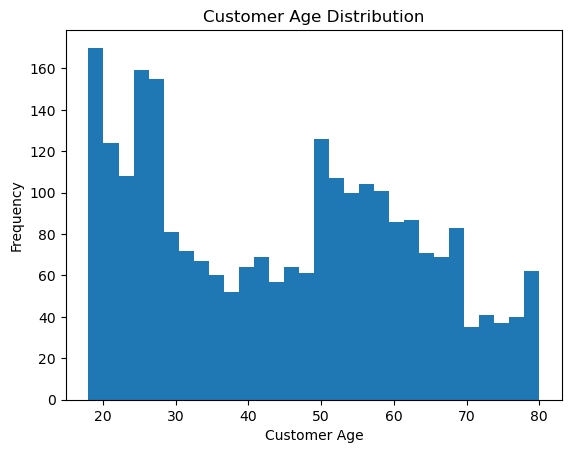

In [9]:
plt.figure()
plt.hist(df["CustomerAge"], bins=30)
plt.title("Customer Age Distribution")
plt.xlabel("Customer Age")
plt.ylabel("Frequency")
plt.show()


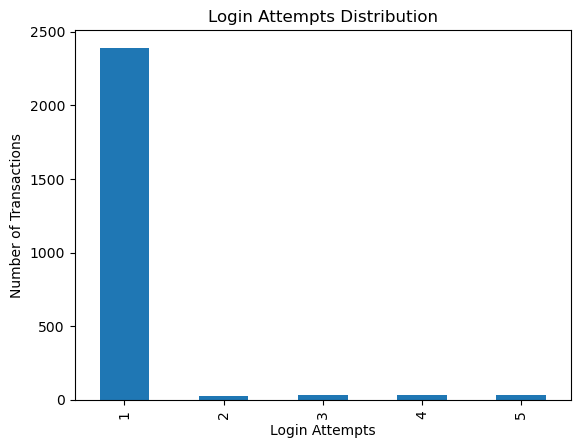

In [10]:
login_counts = df["LoginAttempts"].value_counts().sort_index()

plt.figure()
login_counts.plot(kind="bar")
plt.title("Login Attempts Distribution")
plt.xlabel("Login Attempts")
plt.ylabel("Number of Transactions")
plt.show()


<Figure size 640x480 with 0 Axes>

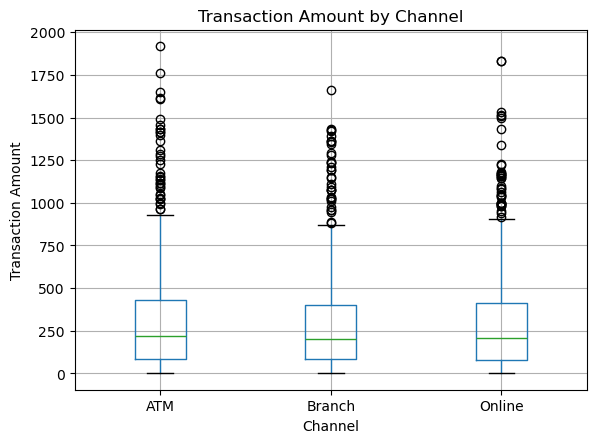

In [11]:
plt.figure()
df.boxplot(column="TransactionAmount", by="Channel")
plt.title("Transaction Amount by Channel")
plt.suptitle("")
plt.xlabel("Channel")
plt.ylabel("Transaction Amount")
plt.show()

In [12]:
high_amount_threshold = df["TransactionAmount"].quantile(0.95)
df["High_Amount_Flag"] = df["TransactionAmount"] > high_amount_threshold

risk_proxy = (
    df.groupby("Channel")["High_Amount_Flag"]
    .mean()
    .sort_values(ascending=False) * 100
)

risk_proxy

Channel
Online    5.672010
ATM       5.402161
Branch    4.032258
Name: High_Amount_Flag, dtype: float64

In [13]:
# การตรวจจับความผิดปกติ (Fraud Detection Logic)

print("\n1. กำลังค้นหาธุรกรรมที่น่าสงสัย...")

# 1: ตรวจสอบยอดเงินที่สูงผิดปกติ กรณีนี้ เราจะใช้ค่าเฉลี่ย + (3 เท่าของส่วนเบี่ยงเบนมาตรฐาน) เป็นเกณฑ์
limit = df['TransactionAmount'].mean() + (3 * df['TransactionAmount'].std())
df['Is_High_Amount'] = df['TransactionAmount'] > limit

# 2: ตรวจสอบการพยายาม Login หลายครั้ง ---
# หาก Login เกิน 3 ครั้ง ถือว่าน่าสงสัย
df['Is_High_Login'] = df['LoginAttempts'] >= 3

#3: ตรวจสอบการใช้ IP เดียวกันแต่หลายบัญชี (เฉพาะ Online) ---
# บัญชีที่ใช้ IP ซ้ำกับคนอื่นในระบบออนไลน์
online_users = df[df['Channel'] == 'Online']
shared_ips = online_users.groupby('IP Address')['AccountID'].nunique()
suspicious_ips = shared_ips[shared_ips > 1].index
df['Is_Shared_IP'] = (df['Channel'] == 'Online') & (df['IP Address'].isin(suspicious_ips))

# 4: ตรวจสอบการเดินทางที่เป็นไปไม่ได้ 
# จัดเรียงข้อมูลตามบัญชีและเวลา
df = df.sort_values(by=['AccountID', 'TransactionDate'])
# หาตำแหน่งก่อนหน้าและเวลาก่อนหน้า
df['Prev_Loc'] = df.groupby('AccountID')['Location'].shift(1)
df['Prev_Time'] = df.groupby('AccountID')['TransactionDate'].shift(1)

# คำนวณระยะห่างเวลา (เป็นชั่วโมง)
time_diff = (df['TransactionDate'] - df['Prev_Time']).dt.total_seconds() / 3600
# ถ้าเปลี่ยนสถานที่ แต่เวลาห่างกันไม่ถึง 1 ชั่วโมง ให้ถือว่าน่าสงสัย
df['Is_Impossible_Travel'] = (df['Location'] != df['Prev_Loc']) & (df['Prev_Loc'].notnull()) & (time_diff < 1)


# สรุปคะแนนความเสี่ยง (Fraud Score)
# รวมคะแนนความเสี่ยงจากทุกกฎ (0 = ปกติ, ยิ่งมากยิ่งเสี่ยง)
df['Fraud_Score'] = (df['Is_High_Amount'].astype(int) + 
                    df['Is_High_Login'].astype(int) + 
                    df['Is_Shared_IP'].astype(int) + 
                    df['Is_Impossible_Travel'].astype(int))

# กรองเฉพาะรายการที่ติด "ธงแดง" (มีคะแนนความเสี่ยงตั้งแต่ 1 ขึ้นไป)
suspicious_list = df[df['Fraud_Score'] > 0].sort_values(by='Fraud_Score', ascending=False)

print(f"พบธุรกรรมที่น่าสงสัยทั้งหมด: {len(suspicious_list)} รายการ")

# บันทึกผลลัพธ์ : เลือกเฉพาะคอลัมน์สำคัญมาแสดงและบันทึกลงไฟล์ใหม่
output_columns = ['TransactionID', 'AccountID', 'TransactionAmount', 'Location', 'Channel', 'Fraud_Score']
suspicious_list[output_columns].to_csv('suspicious_report.csv', index=False)

print("\nบันทึกรายงานธุรกรรมที่น่าสงสัยลงไฟล์ 'suspicious_report.csv' เรียบร้อยแล้ว")


1. กำลังค้นหาธุรกรรมที่น่าสงสัย...
พบธุรกรรมที่น่าสงสัยทั้งหมด: 716 รายการ

บันทึกรายงานธุรกรรมที่น่าสงสัยลงไฟล์ 'suspicious_report.csv' เรียบร้อยแล้ว
